In [31]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
from datetime import datetime

In [32]:
df = pd.read_csv('data/clean.csv')
# Define the order of seasons
season_order = ["Winter", "Spring", "Summer", "Fall"]

# Split the 'Recipient Graduation Date' column into season and year
df[["Season", "Year"]] = df["Recipient Graduation Date"].str.split(" ", expand=True)
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

# Map season names to an order index (for comparison)
df["Season_num"] = df["Season"].map({s: i for i, s in enumerate(season_order)})

# Define the cutoff (Winter 2025)
cutoff_year = 2025
cutoff_season_num = season_order.index("Winter")

# Filter out data *after* Winter 2025
df = df[
    (df["Year"] < cutoff_year) |
    ((df["Year"] == cutoff_year) & (df["Season_num"] <= cutoff_season_num))
].copy()


In [33]:
df["Recipient Graduation Date"].value_counts()

Recipient Graduation Date
Winter 2023    490
Winter 2025    397
Winter 2024    389
Fall 2024      161
Fall 2023      111
Summer 2023     71
Summer 2024     43
Name: count, dtype: int64

In [34]:
def remove_outliers_iqr(series):
    """Remove outliers based on 1.5×IQR rule."""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series[(series >= lower) & (series <= upper)]

In [35]:
import pandas as pd
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df["SPORT_1"].notna(), df["Outcome Category"])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-square test p-value = {p:.4f}")


Chi-square test p-value = 0.0365


In [36]:
from scipy.stats import ttest_ind

# Separate groups
sport_salary = df[df["SPORT_1"].notna()]["Annual Salary"].dropna()
no_sport_salary = df[df["SPORT_1"].isna()]["Annual Salary"].dropna()

# Remove outliers in each group
sport_salary = remove_outliers_iqr(sport_salary)
no_sport_salary = remove_outliers_iqr(no_sport_salary)

# Perform Welch’s t-test (unequal variances)
t, p = ttest_ind(sport_salary, no_sport_salary, equal_var=False)
print(f"T-test p-value = {p:.4f}")

T-test p-value = 0.4226


In [37]:
from scipy.stats import f_oneway

# Remove outliers per group
groups = []
for emp_type, group in df.groupby("Employment Type"):
    cleaned = remove_outliers_iqr(group["Annual Salary"].dropna())
    if len(cleaned) > 1:  # skip empty or single-value groups
        groups.append(cleaned)

# Run one-way ANOVA
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA p-value = {p_val:.4f}")

ANOVA p-value = 0.0000



===== Chi-square Tests: Relationship with Outcome Category =====
                  Feature       Chi2      p-value  DoF  Significant (<0.05)
Recipient Graduation Date 406.357322 1.704529e-79   12                 True
Recipient Primary College 144.855757 7.656983e-24   14                 True
  Recipient Primary Major 345.631462 4.744732e-21  132                 True
                  SPORT_1  84.198568 2.515971e-04   44                 True
                RESIDENCY  20.542021 8.468826e-03    8                 True
                     FTPT   7.492966 2.360060e-02    2                 True
                      SEX   8.478239 7.554959e-02    4                False


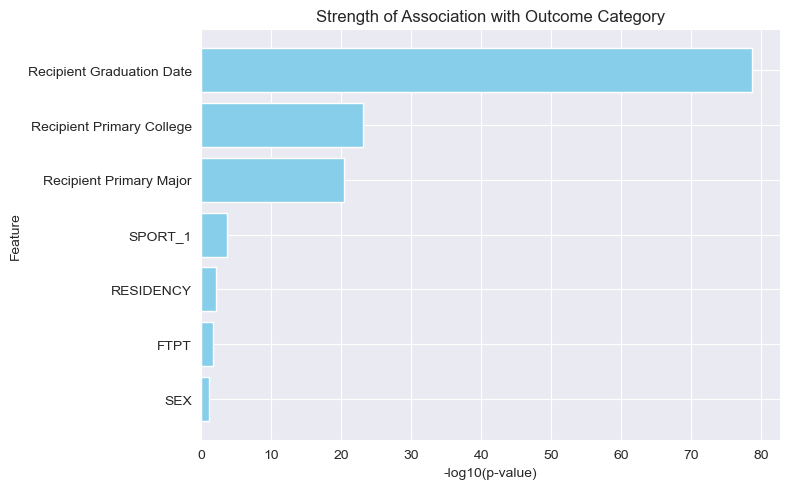

In [38]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# --- Step 1: Define features and clean data ---
features = [
    "Recipient Primary Major",
    "SPORT_1",
    "Recipient Primary College",
    "Recipient Graduation Date",
    "FTPT",
    "SEX",
    "RESIDENCY"
]

df_clean = df.copy()
df_clean = df_clean.dropna(subset=["Outcome Category"])

results = []

# --- Step 2: Perform Chi-square test for each feature ---
for feature in features:
    if feature not in df_clean.columns:
        print(f"⚠️ Skipping {feature} — not found in DataFrame.")
        continue

    # Drop rows with missing feature
    sub = df_clean.dropna(subset=[feature, "Outcome Category"])

    # Build contingency table
    contingency = pd.crosstab(sub[feature], sub["Outcome Category"])

    # Skip if not enough categories to test
    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        print(f"⚠️ Skipping {feature} — insufficient unique values for Chi-square.")
        continue

    try:
        chi2, p, dof, expected = chi2_contingency(contingency)
        results.append((feature, chi2, p, dof))
    except Exception as e:
        print(f"⚠️ Error testing {feature}: {e}")
        continue

# --- Step 3: Compile and display results ---
results_df = pd.DataFrame(results, columns=["Feature", "Chi2", "p-value", "DoF"])
results_df["Significant (<0.05)"] = results_df["p-value"] < 0.05
results_df = results_df.sort_values("p-value")

print("\n===== Chi-square Tests: Relationship with Outcome Category =====")
print(results_df.to_string(index=False))

# --- Optional: Visualize strongest associations ---
import matplotlib.pyplot as plt

top = results_df.sort_values("p-value").head(7)
plt.figure(figsize=(8,5))
plt.barh(top["Feature"], -np.log10(top["p-value"]), color="skyblue")
plt.xlabel("-log10(p-value)")
plt.ylabel("Feature")
plt.title("Strength of Association with Outcome Category")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()




===== Chi-square Tests with Cramér’s V: Relationship with Outcome Category =====
                  Feature       Chi2      p-value  DoF  Cramér's V  Significant (<0.05)
Recipient Graduation Date 406.357322 1.704529e-79   12    0.349642                 True
Recipient Primary College 144.855757 7.656983e-24   14    0.208881                 True
  Recipient Primary Major 345.631462 4.744732e-21  132    0.322460                 True
                  SPORT_1  84.198568 2.515971e-04   44    0.425069                 True
                RESIDENCY  20.542021 8.468826e-03    8    0.078612                 True
                     FTPT   7.492966 2.360060e-02    2    0.067145                 True
                      SEX   8.478239 7.554959e-02    4    0.050504                False


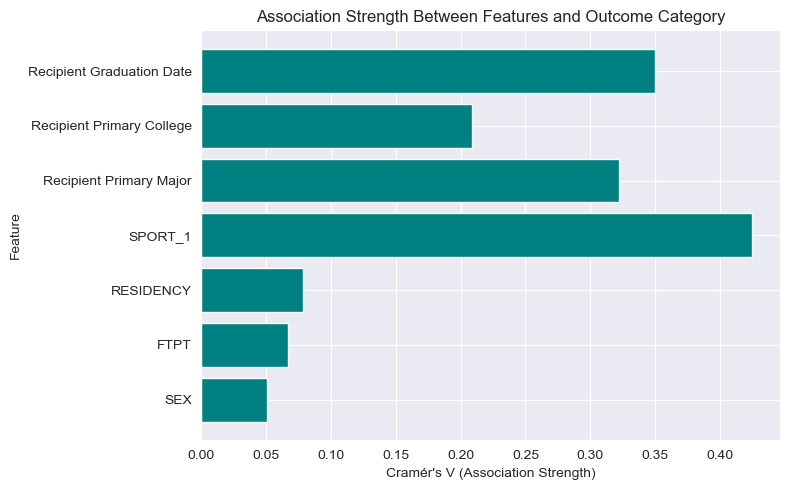

In [39]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# --- Step 1: Define relevant features ---
features = [
    "Recipient Primary Major",
    "SPORT_1",
    "Recipient Primary College",
    "Recipient Graduation Date",
    "FTPT",
    "SEX",
    "RESIDENCY"
]

# --- Step 2: Clean data ---
df_clean = df.copy()
df_clean = df_clean.dropna(subset=["Outcome Category"])

results = []

# --- Helper: Compute Cramér’s V ---
def cramers_v(confusion_matrix):
    """Compute Cramér’s V for a given contingency table."""
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.to_numpy().sum()
    r, k = confusion_matrix.shape
    return np.sqrt((chi2 / n) / (min(k - 1, r - 1)))

# --- Step 3: Run Chi-square + Cramér’s V for each feature ---
for feature in features:
    if feature not in df_clean.columns:
        print(f"⚠️ Skipping {feature} — not found in DataFrame.")
        continue

    # Drop rows with missing data in the feature or outcome
    sub = df_clean.dropna(subset=[feature, "Outcome Category"])

    contingency = pd.crosstab(sub[feature], sub["Outcome Category"])

    # Skip if insufficient categories
    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        print(f"⚠️ Skipping {feature} — insufficient unique values for Chi-square.")
        continue

    try:
        chi2, p, dof, expected = chi2_contingency(contingency)
        v = cramers_v(contingency)
        results.append((feature, chi2, p, dof, v))
    except Exception as e:
        print(f"⚠️ Error testing {feature}: {e}")
        continue

# --- Step 4: Summarize results ---
results_df = pd.DataFrame(results, columns=["Feature", "Chi2", "p-value", "DoF", "Cramér's V"])
results_df["Significant (<0.05)"] = results_df["p-value"] < 0.05
results_df = results_df.sort_values("p-value")

# --- Step 5: Print results ---
print("\n===== Chi-square Tests with Cramér’s V: Relationship with Outcome Category =====")
print(results_df.to_string(index=False))

# --- Step 6: Plot association strength ---
plt.figure(figsize=(8,5))
plt.barh(results_df["Feature"], results_df["Cramér's V"], color="teal")
plt.xlabel("Cramér's V (Association Strength)")
plt.ylabel("Feature")
plt.title("Association Strength Between Features and Outcome Category")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


📊 Chi-square Test for Outcome Category vs Year
Chi² = 228.046, p = 0.0000, dof = 4
➡️ Significant change in outcome distribution over time.

📈 Spearman Rank Correlation (Outcome Trend over Time)
ρ = 0.500, p = 0.6667
❌ No significant monotonic trend in outcomes over years.


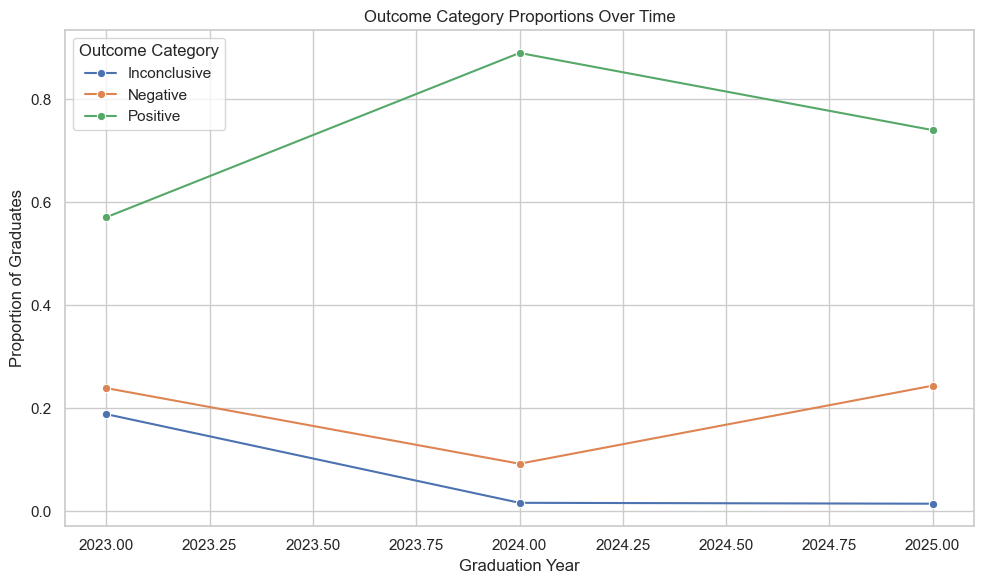

In [40]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Prepare data ---
df_time = df.copy()

# Ensure Year is numeric and filtered properly
df_time = df_time[df_time["Year"].notna()].copy()
df_time["Year"] = df_time["Year"].astype(int)
df_time = df_time[df_time["Year"] <= 2025]  # remove any after Winter 2025

# --- Step 2: Encode Outcome Category ---
# Map outcomes to numeric scale for correlation trend test
outcome_map = {"Negative": 0, "Inconclusive": 1, "Positive": 2}
df_time["OutcomeNum"] = df_time["Outcome Category"].map(outcome_map)

# --- Step 3: Compute yearly proportions ---
year_outcome = (
    df_time.groupby(["Year", "Outcome Category"])
           .size()
           .reset_index(name="Count")
)
total_per_year = year_outcome.groupby("Year")["Count"].sum().reset_index(name="Total")
year_outcome = year_outcome.merge(total_per_year, on="Year")
year_outcome["Proportion"] = year_outcome["Count"] / year_outcome["Total"]

# --- Step 4: Chi-square test for trend ---
# Build contingency table: rows = years, cols = outcome categories
contingency = pd.crosstab(df_time["Year"], df_time["Outcome Category"])

chi2, p, dof, expected = stats.chi2_contingency(contingency)

print("📊 Chi-square Test for Outcome Category vs Year")
print(f"Chi² = {chi2:.3f}, p = {p:.4f}, dof = {dof}")
if p < 0.05:
    print("➡️ Significant change in outcome distribution over time.")
else:
    print("❌ No significant change in outcome distribution over time.")

# --- Step 5: Spearman rank correlation (ordinal trend) ---
# Average outcome score per year
avg_outcome_per_year = df_time.groupby("Year")["OutcomeNum"].mean().reset_index()

rho, p_spear = stats.spearmanr(avg_outcome_per_year["Year"], avg_outcome_per_year["OutcomeNum"])

print("\n📈 Spearman Rank Correlation (Outcome Trend over Time)")
print(f"ρ = {rho:.3f}, p = {p_spear:.4f}")
if p_spear < 0.05:
    print("➡️ Significant monotonic trend in average outcome category over years.")
else:
    print("❌ No significant monotonic trend in outcomes over years.")

# --- Step 6: Visualization ---
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.lineplot(data=year_outcome, x="Year", y="Proportion", hue="Outcome Category", marker="o")
plt.title("Outcome Category Proportions Over Time")
plt.ylabel("Proportion of Graduates")
plt.xlabel("Graduation Year")
plt.legend(title="Outcome Category")
plt.tight_layout()
plt.show()
